In [0]:
- 問題設定
1. 時系列がy(t)とfeat(t)２つ与えられ(yはt時点、featはt+α時点まで与えられている)、y(t+β) (β＞α)を予測したい。
2. 時系列y(t)とfeat(t)は相関がある。（yがfeatを含んでいる。y(t)=c1*feat(t)+other(t)))

In [0]:
- 流れ
1. t+α時点までのfeatデータ実測値のみを用いてt+α〜t+β時点のfeatを予測する。
2. t+α時点までのfeat実測値＋t+α〜t+β時点のfeat予測値(add_regressorで説明変数として追加)とt時点までのy実測値を用いてt〜t+β時点のyを予測する。
3. y実測値のみ用いたy予測と、feat実測＋予測値を説明変数として追加した場合のy予測で、予測精度が向上するかを確認する。

In [0]:
from datetime import datetime, timedelta
from fbprophet import  Prophet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [0]:
START_DT = '2018-09-01'
END_DT = '2019-09-05'

In [0]:
dts = pd.date_range(START_DT, END_DT, freq='D')

In [0]:
TIME_LEN = len(dts)

In [89]:
TIME_LEN

370

In [0]:
feat1 = np.sin(0.1 * np.arange(TIME_LEN)) \
        + np.cos(0.03 * np.arange(TIME_LEN)) \
        + 0.01*np.arange(TIME_LEN) \
        + 0.3*np.random.randn(TIME_LEN)

In [0]:
feat_scaler = MinMaxScaler((0, 0.1))

In [0]:
feat1 = feat_scaler.fit_transform(feat1.reshape(-1, 1)).flatten()

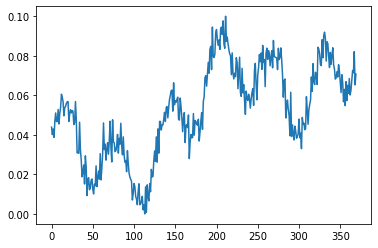

In [229]:
plt.plot(feat1)

In [0]:
y = 0.6 * feat1 + 0.2 * feat1.max() * np.sin(0.2 * np.arange(TIME_LEN)) + 0.05*feat1.max() *np.random.randn(TIME_LEN)
# y *= 100

In [0]:
y_scaler = MinMaxScaler((0, 0.1))

In [0]:
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

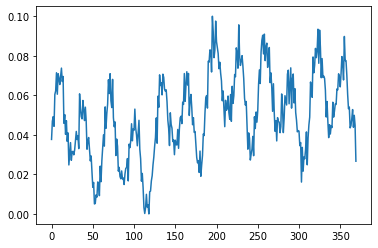

In [233]:
plt.plot(y)

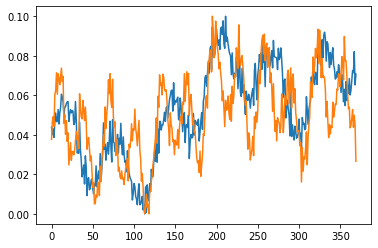

In [234]:
plt.plot(feat1)
plt.plot(y)

In [0]:
df = pd.DataFrame({
    'datetime': dts,
    'y': y,
    'feat1': feat1
})

In [0]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [0]:
df.set_index('datetime', inplace=True)

In [0]:
ALPHA_D = 20

In [0]:
df['feat1_lag'] = df['feat1'].shift(-ALPHA_D)

In [0]:
df.dropna(how='any', inplace=True)

In [0]:
pd.plotting.register_matplotlib_converters()

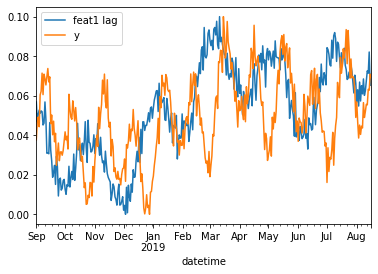

In [242]:
df['feat1_lag'].plot(label='feat1 lag')
df['y'].plot(label='y')
plt.legend()

In [0]:
from sklearn.model_selection import TimeSeriesSplit

In [0]:
splits = TimeSeriesSplit(n_splits=3)

In [214]:
for train_index, test_index in splits.split(df):
    print(f'{len(train_index)} : {len(test_index)}')

89 : 87
176 : 87
263 : 87


In [0]:
SEQ_LEN = 20

In [0]:
df['ds'] = df.index

In [0]:
### 目的変数のみ　/ Prophet素

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


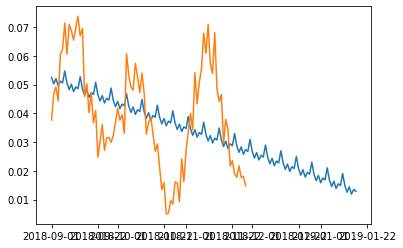

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


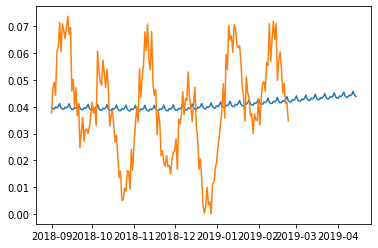

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


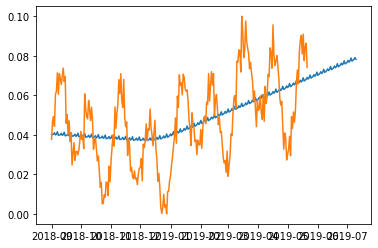

In [246]:
for train_index, test_index in splits.split(df):
    m = Prophet()
    df_train = df.iloc[train_index]
    m.fit(df_train)
    future = m.make_future_dataframe(periods=50)
    forecast = m.predict(future)

    plt.plot(forecast['ds'], forecast['yhat'])
    plt.plot(df_train.index, df_train['y'])
    plt.show()

In [0]:
### 目的変数のみ　/ Prophetチューニング (add_seasonalityで周期の指定)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


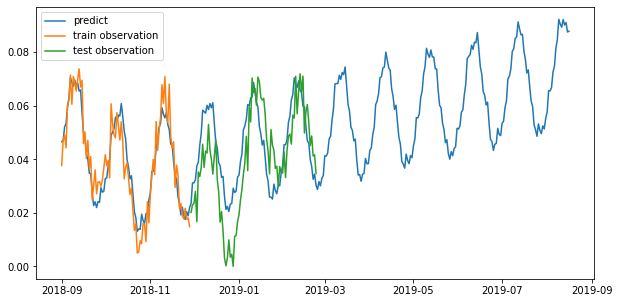

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


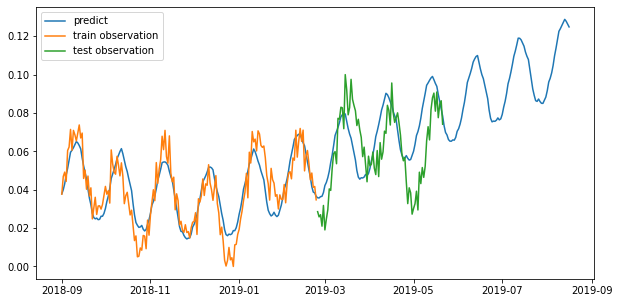

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


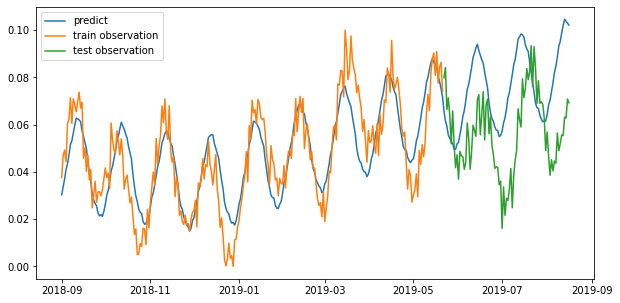

In [381]:
for train_index, test_index in splits.split(df):
    m = Prophet()
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]
    m.add_seasonality(name='day', period=30.5, fourier_order=5)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=100)
    forecast = m.predict(df)

    plt.figure(figsize=(10, 5))
    plt.plot(forecast['ds'], forecast['yhat'], label='predict')
    plt.plot(df_train.index, df_train['y'], label='train observation')
    plt.plot(df_test.index, df_test['y'], label='test observation')
    plt.legend()
    plt.show()

In [0]:
### featを説明変数として追加（※α=β想定）　/ Prophetチューニング (add_seasonalityで周期の指定)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-11-28 00:00:00


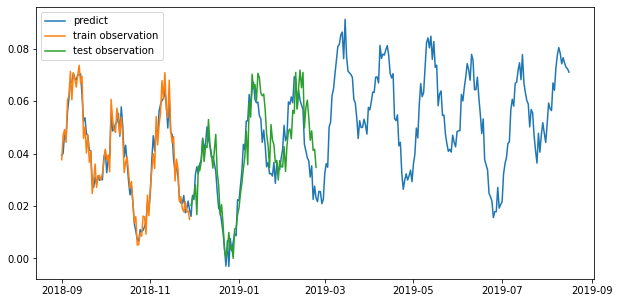

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-02-23 00:00:00


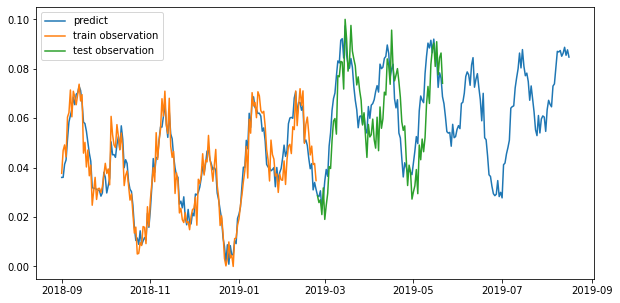

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-05-21 00:00:00


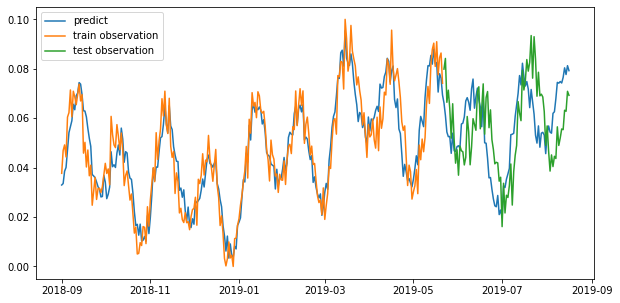

In [275]:
for train_index, test_index in splits.split(df):
    m = Prophet()
    df_train = df.iloc[train_index]
    print(df_train.index.max())
    df_test = df.iloc[test_index]
    m.add_seasonality(name='day', period=30.5, fourier_order=5)
    m.add_regressor('feat1')
    m.fit(df_train)
    future = m.make_future_dataframe(periods=50, freq='D')
    forecast = m.predict(df)

    plt.figure(figsize=(10, 5))
    plt.plot(forecast['ds'], forecast['yhat'], label='predict')
    plt.plot(df_train.index, df_train['y'], label='train observation')
    plt.plot(df_test.index, df_test['y'], label='test observation')
    plt.legend()
    plt.show()

In [0]:
df_feat = df[['feat1']]

In [289]:
df_feat

,feat1
datetime,
2018-09-01,0.043886
2018-09-02,0.040106
2018-09-03,0.042975
2018-09-04,0.038717
2018-09-05,0.046747
...,...
2019-08-12,0.068779
2019-08-13,0.071936
2019-08-14,0.069248


In [313]:
df_feat['y'] = df_feat['feat1']
df_feat['ds'] = df_feat.index

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [314]:
df_feat

,feat1,y,ds
datetime,,,
2018-09-01,0.043886,0.043886,2018-09-01
2018-09-02,0.040106,0.040106,2018-09-02
2018-09-03,0.042975,0.042975,2018-09-03
2018-09-04,0.038717,0.038717,2018-09-04
2018-09-05,0.046747,0.046747,2018-09-05
...,...,...,...
2019-08-12,0.068779,0.068779,2019-08-12
2019-08-13,0.071936,0.071936,2019-08-13
2019-08-14,0.069248,0.069248,2019-08-14


In [0]:
ALPHA_DAY = 60  # day
BETA_DAY = 90  # day

In [0]:
#NOW_DT = '2019-03-01'
NOW_DT = '2019-04-01'

In [0]:
ALPHA_DT = datetime.strptime(NOW_DT, '%Y-%m-%d') + timedelta(days=ALPHA_DAY)
BETA_DT = datetime.strptime(NOW_DT, '%Y-%m-%d') + timedelta(days=BETA_DAY)

In [0]:
df_feat_train = df_feat[df_feat.index < ALPHA_DT]
df_feat_test = df_feat[df_feat.index >= ALPHA_DT]

In [367]:
df_feat_train

,feat1,y,ds
datetime,,,
2018-09-01,0.043886,0.043886,2018-09-01
2018-09-02,0.040106,0.040106,2018-09-02
2018-09-03,0.042975,0.042975,2018-09-03
2018-09-04,0.038717,0.038717,2018-09-04
2018-09-05,0.046747,0.046747,2018-09-05
...,...,...,...
2019-05-26,0.082594,0.082594,2019-05-26
2019-05-27,0.073906,0.073906,2019-05-27
2019-05-28,0.087754,0.087754,2019-05-28


In [368]:
m_feat = Prophet()
m_feat.add_seasonality(name='day', period=60.5, fourier_order=5)
m_feat.fit(df_feat_train)
future = m_feat.make_future_dataframe(periods=BETA_DAY-ALPHA_DAY, freq='D')
feat_pred = m_feat.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [369]:
feat_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day,day_lower,day_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-09-01,0.043991,0.026679,0.041622,0.043991,0.043991,-0.009274,-0.009274,-0.009274,-0.009194,-0.009194,-0.009194,-0.000080,-0.000080,-0.000080,0.0,0.0,0.0,0.034718
1,2018-09-02,0.043734,0.029311,0.043950,0.043734,0.043734,-0.007134,-0.007134,-0.007134,-0.007268,-0.007268,-0.007268,0.000134,0.000134,0.000134,0.0,0.0,0.0,0.036600
2,2018-09-03,0.043478,0.030718,0.045672,0.043478,0.043478,-0.005386,-0.005386,-0.005386,-0.005214,-0.005214,-0.005214,-0.000172,-0.000172,-0.000172,0.0,0.0,0.0,0.038092
3,2018-09-04,0.043221,0.032578,0.047531,0.043221,0.043221,-0.003256,-0.003256,-0.003256,-0.003103,-0.003103,-0.003103,-0.000152,-0.000152,-0.000152,0.0,0.0,0.0,0.039965
4,2018-09-05,0.042964,0.034647,0.049641,0.042964,0.042964,-0.001018,-0.001018,-0.001018,-0.001002,-0.001002,-0.001002,-0.000016,-0.000016,-0.000016,0.0,0.0,0.0,0.041946


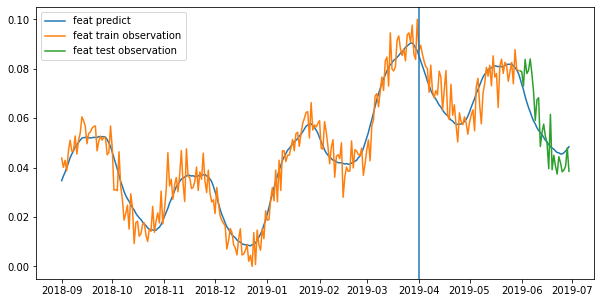

In [379]:
plt.figure(figsize=(10, 5))
plt.plot(feat_pred['ds'], feat_pred['yhat'], label='feat predict')
plt.plot(df_feat_train.index, df_feat_train['y'], label='feat train observation')
plt.plot(df_feat_test[df_feat_test.index < BETA_DT].index, df_feat_test[df_feat_test.index < BETA_DT]['y'], label='feat test observation')
# plt.plot(df[df.index < NOW_DT].index, df[df.index < NOW_DT]['y'], label='y observation')
plt.axvline(NOW_DT, ymin=0, ymax=2)
plt.legend()
plt.show()

In [0]:
df_train = df[df.index < NOW_DT]
df_test = df[df.index >= NOW_DT]

In [0]:
feat_pred['feat1'] = feat_pred['yhat']

In [373]:
m = Prophet()
m.add_seasonality(name='day', period=30.5, fourier_order=5)
m.add_regressor('feat1')
m.fit(df_train)
# future = m.make_future_dataframe(periods=50, freq='D')
y_pred_with_feat = m.predict(feat_pred)

m2 = Prophet()
m2.add_seasonality(name='day', period=30.5, fourier_order=5)
m2.fit(df_train)
# future = m.make_future_dataframe(periods=50, freq='D')
y_pred = m2.predict(feat_pred)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


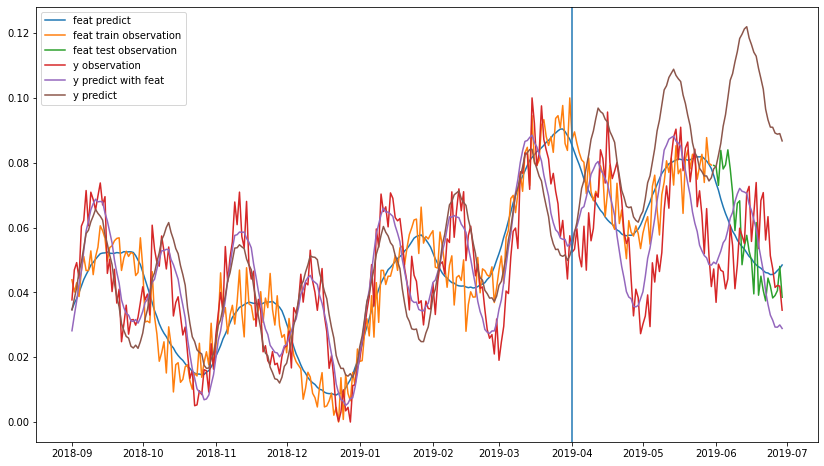

In [374]:
plt.figure(figsize=(14, 8))
plt.plot(feat_pred['ds'], feat_pred['yhat'], label='feat predict')
plt.plot(df_feat_train.index, df_feat_train['y'], label='feat train observation')
plt.plot(df_feat_test[df_feat_test.index < BETA_DT].index, df_feat_test[df_feat_test.index < BETA_DT]['y'], label='feat test observation')
plt.plot(df[df.index < BETA_DT].index, df[df.index < BETA_DT]['y'], label='y observation')
plt.plot(y_pred_with_feat['ds'], y_pred_with_feat['yhat'], label='y predict with feat')
plt.plot(y_pred['ds'], y_pred['yhat'], label='y predict')
plt.axvline(NOW_DT, ymin=0, ymax=2)
plt.legend()
plt.show()

In [0]:
### y単体でyを予測したした場合とfeatの実測＋予測を説明変数として追加してyを予測した場合の比較

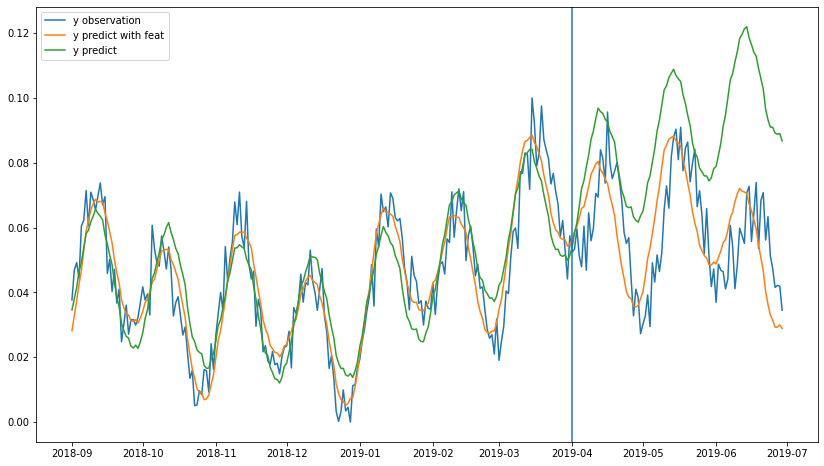

In [375]:
plt.figure(figsize=(14, 8))
plt.plot(df[df.index < BETA_DT].index, df[df.index < BETA_DT]['y'], label='y observation')
plt.plot(y_pred_with_feat['ds'], y_pred_with_feat['yhat'], label='y predict with feat')
plt.plot(y_pred['ds'], y_pred['yhat'], label='y predict')
plt.axvline(NOW_DT, ymin=0, ymax=2)
plt.legend()
plt.show()

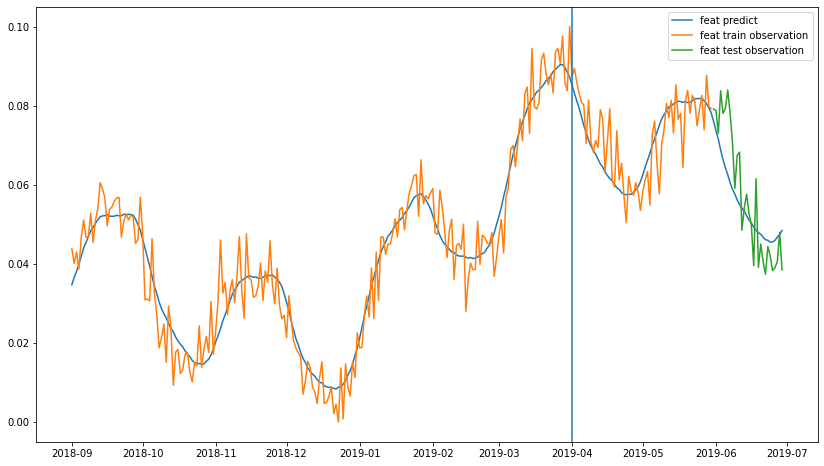

In [376]:
plt.figure(figsize=(14, 8))
plt.plot(feat_pred['ds'], feat_pred['yhat'], label='feat predict')
plt.plot(df_feat_train.index, df_feat_train['y'], label='feat train observation')
plt.plot(df_feat_test[df_feat_test.index < BETA_DT].index, df_feat_test[df_feat_test.index < BETA_DT]['y'], label='feat test observation')
plt.axvline(NOW_DT, ymin=0, ymax=2)
plt.legend()
plt.show()